## Start

In [1]:
import optuna
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import optuna.visualization as vis
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import PolynomialFeatures, StandardScaler
from sklearn.ensemble import RandomForestClassifier, StackingClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import StratifiedKFold, train_test_split, cross_val_score, learning_curve
from sklearn.metrics import brier_score_loss, roc_auc_score
from sklearn.calibration import calibration_curve, CalibratedClassifierCV

import warnings
warnings.filterwarnings("ignore")

In [2]:
train = pd.read_csv("train_2.csv")
test = pd.read_csv("test_2.csv")

In [3]:
X = train.drop('smoking', axis=1)
y = train['smoking']

SEED = 1

skf = StratifiedKFold(n_splits=5, shuffle=True, random_state=SEED)

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, stratify=y, random_state=SEED)

## Feature Selection

Я решил создать стэк RandomForestClassifier и LogisticRegression. FS буду делать именно под эти модели

In [4]:
rf_pipeline = Pipeline([
    ('rf', RandomForestClassifier(random_state=SEED))
])

lr_pipeline = Pipeline([
    ('scaler', StandardScaler()),
    ('lr', LogisticRegression(random_state=SEED))
])

stacking_model = StackingClassifier(
    estimators=[
        ('rf_pipeline', rf_pipeline),
        ('lr_pipeline', lr_pipeline)
    ],
    final_estimator=LogisticRegression(random_state=SEED),
    cv=skf
)

In [5]:
cvs = cross_val_score(stacking_model, X_train, y_train, cv=skf, n_jobs=-1, scoring='roc_auc').mean()

np.round(cvs, 5)

0.88155

In [6]:
stacking_model.fit(X_train, y_train)

StackingClassifier(cv=StratifiedKFold(n_splits=5, random_state=1, shuffle=True),
                   estimators=[('rf_pipeline',
                                Pipeline(steps=[('rf',
                                                 RandomForestClassifier(random_state=1))])),
                               ('lr_pipeline',
                                Pipeline(steps=[('scaler', StandardScaler()),
                                                ('lr',
                                                 LogisticRegression(random_state=1))]))],
                   final_estimator=LogisticRegression(random_state=1))

Признаки для RandomForest:

In [7]:
rf_model = stacking_model.named_estimators_['rf_pipeline'].named_steps['rf']


importances = rf_model.feature_importances_

feature_importance_df = pd.DataFrame({
    'Feature': X_train.columns,
    'Importance': importances
}).sort_values(by='Importance', ascending=False)

print(feature_importance_df)

                    Feature  Importance
15               hemoglobin    0.090647
1                height(cm)    0.080955
23           height(cm)_cat    0.073664
12             triglyceride    0.059733
20                      Gtp    0.051056
35           hemoglobin_cat    0.044100
39                  Gtp_cat    0.043682
14                      LDL    0.034473
2                weight(kg)    0.033486
11              Cholesterol    0.033003
13                      HDL    0.031763
10      fasting blood sugar    0.030514
19                      ALT    0.030318
3                 waist(cm)    0.029678
8                  systolic    0.028141
18                      AST    0.027739
17         serum creatinine    0.027649
9                relaxation    0.026476
0                       age    0.023090
24           weight(kg)_cat    0.019923
32         triglyceride_cat    0.017965
5           eyesight(right)    0.016374
36     serum creatinine_cat    0.015830
4            eyesight(left)    0.015540


Признаки для Logistic Regression:

In [8]:
lr_model = stacking_model.named_estimators_['lr_pipeline'].named_steps['lr']

coefficients = lr_model.coef_[0]

coef_df = pd.DataFrame({
    'Feature': X_train.columns,
    'Coefficient': coefficients
}).sort_values(by='Coefficient', ascending=False)

print(coef_df)

                    Feature  Coefficient
23           height(cm)_cat     0.928772
15               hemoglobin     0.783935
39                  Gtp_cat     0.620182
20                      Gtp     0.272248
12             triglyceride     0.212107
1                height(cm)     0.209984
21            dental caries     0.200946
32         triglyceride_cat     0.148486
26       eyesight(left)_cat     0.132227
27      eyesight(right)_cat     0.125778
36     serum creatinine_cat     0.097454
29           relaxation_cat     0.088989
22                  age_cat     0.080819
0                       age     0.034325
31          Cholesterol_cat     0.008153
30  fasting blood sugar_cat     0.003556
10      fasting blood sugar     0.001059
6             hearing(left)     0.000000
7            hearing(right)     0.000000
14                      LDL    -0.041512
3                 waist(cm)    -0.041918
37                  AST_cat    -0.041931
35           hemoglobin_cat    -0.046276
24           wei

Посмотрел на верхние результаты и, после некоторых экспериментов, выбрал вот эти признаки:

In [9]:
columns = [
    'age',
    'age_cat',
    'height(cm)',
    'height(cm)_cat',
    'weight(kg)_cat',
    'waist(cm)',
    'waist(cm)_cat',
    'eyesight(right)',
    'eyesight(right)_cat',
    'systolic',
    'fasting blood sugar_cat',
    'Cholesterol',
    'triglyceride',
    'LDL',
    'hemoglobin',
    'hemoglobin_cat',
    'serum creatinine',
    'serum creatinine_cat',
    'AST',
    'ALT',
    'Gtp',
    'dental caries'
]

In [10]:
train[columns + ['smoking']].to_csv('train_3.csv', index=False)
test[columns].to_csv('test_3.csv', index=False)

## HPO

In [11]:
def objective(trial):
    rf_max_depth = trial.suggest_int('rf_max_depth', 5, 20)
    rf_min_samples_split = trial.suggest_int('rf_min_samples_split', 2, 15)
    rf_min_samples_leaf = trial.suggest_int('rf_min_samples_leaf', 1, 15)
    rf_max_features = trial.suggest_int('rf_max_features', 4, 20)

    rf_pipeline = Pipeline([
        ('rf', RandomForestClassifier(
            criterion='entropy',
            max_depth=rf_max_depth,
            min_samples_split=rf_min_samples_split,
            min_samples_leaf=rf_min_samples_leaf,
            max_features=rf_max_features,
            random_state=SEED
        ))
    ])

    lr_C = trial.suggest_loguniform('lr_C', 1e-4, 1e1)
    
    lr_pipeline = Pipeline([
        ('scaler', StandardScaler()),
        ('poly', PolynomialFeatures(degree=2, include_bias=False)),
        ('lr', LogisticRegression(C=lr_C, random_state=SEED))
    ])

    lr_C_2 = trial.suggest_loguniform('lr_C_2', 1e-4, 1e1)
    
    stacking_model = StackingClassifier(
        estimators=[
            ('rf_pipeline', rf_pipeline),
            ('lr_pipeline', lr_pipeline)
        ],
        final_estimator=LogisticRegression(C=lr_C_2, random_state=SEED),
        cv=skf
    )

    train_score = cross_val_score(stacking_model, X_train, y_train, cv=skf, n_jobs=-1, scoring='roc_auc').mean()
    test_score = cross_val_score(stacking_model, X_test, y_test, cv=skf, n_jobs=-1, scoring='roc_auc').mean()
    
    # Минимизация разницы между обучением и тестом для уменьшения переобучения
    difference = abs(train_score - test_score)
    score = test_score - difference
    
    return score

study = optuna.create_study(
    storage='sqlite:///optuna.db',
    study_name='My study',
    load_if_exists=True,
    direction='maximize'
)

study.optimize(objective, n_trials=10)

trial = study.best_trial

print("Best trial:")
print(f"Value: {trial.value}")
print("Params:")
for key, value in trial.params.items():
    print(f"    {key}: {value}")


[I 2024-10-31 10:00:49,239] Using an existing study with name 'My study' instead of creating a new one.
[I 2024-10-31 10:02:12,847] Trial 100 finished with value: 0.8837944422411145 and parameters: {'rf_max_depth': 17, 'rf_min_samples_split': 6, 'rf_min_samples_leaf': 2, 'rf_max_features': 11, 'lr_C': 0.04120991071069159, 'lr_C_2': 5.621812799263172}. Best is trial 53 with value: 0.8846829143196233.
[I 2024-10-31 10:03:21,619] Trial 101 finished with value: 0.8840136155848649 and parameters: {'rf_max_depth': 14, 'rf_min_samples_split': 10, 'rf_min_samples_leaf': 4, 'rf_max_features': 9, 'lr_C': 0.01053363931251379, 'lr_C_2': 1.2015621615202667}. Best is trial 53 with value: 0.8846829143196233.
[I 2024-10-31 10:04:34,626] Trial 102 finished with value: 0.8839648606981939 and parameters: {'rf_max_depth': 14, 'rf_min_samples_split': 9, 'rf_min_samples_leaf': 4, 'rf_max_features': 9, 'lr_C': 0.009195806166328398, 'lr_C_2': 1.7757592322712301}. Best is trial 53 with value: 0.884682914319623

Best trial:
Value: 0.8846829143196233
Params:
    rf_max_depth: 14
    rf_min_samples_split: 8
    rf_min_samples_leaf: 2
    rf_max_features: 7
    lr_C: 0.020105502314296263
    lr_C_2: 6.45381451839563


Глянем какие параметры влияли а какие нет

In [12]:
vis.plot_param_importances(study).show()

In [13]:
rf_pipeline = Pipeline([
    ('rf', RandomForestClassifier(criterion='entropy',
                                  max_depth=14,
                                  min_samples_split=8,
                                  min_samples_leaf=2,
                                  max_features=7,
                                  random_state=SEED))
])

lr_pipeline = Pipeline([
    ('scaler', StandardScaler()),
    ('poly', PolynomialFeatures(degree=2, include_bias=False)),
    ('lr', LogisticRegression(C=0.02, random_state=SEED))
])

stacking_model = StackingClassifier(
    estimators=[
        ('rf_pipeline', rf_pipeline),
        ('lr_pipeline', lr_pipeline)
    ],
    final_estimator=LogisticRegression(C=6.45, random_state=SEED),
    cv=skf
)

## Learning curve

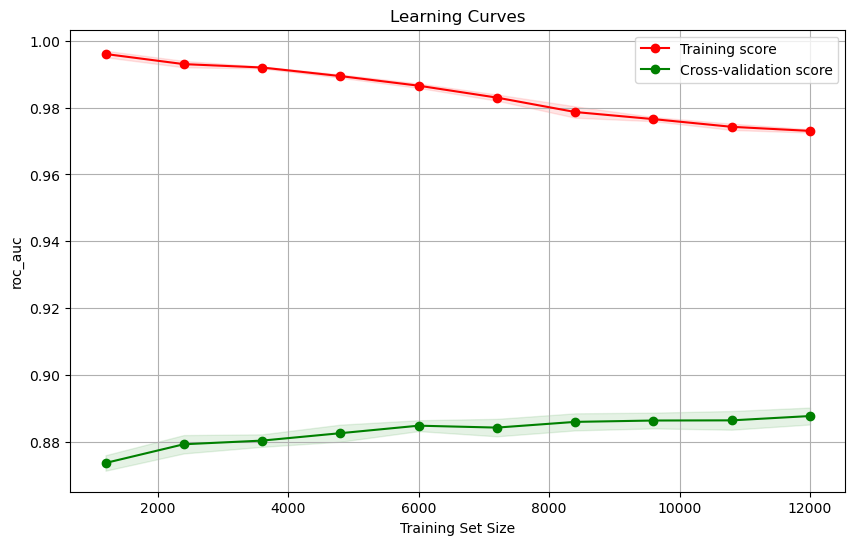

In [14]:
def plot_learning_curves(estimator, X, y, scoring='roc_auc', cv=skf):
    train_sizes, train_scores, test_scores = learning_curve(
        estimator, X, y, cv=cv, scoring=scoring, train_sizes=np.linspace(0.1, 1.0, 10), n_jobs=-1
    )
    
    train_scores_mean = np.mean(train_scores, axis=1)
    train_scores_std = np.std(train_scores, axis=1)
    test_scores_mean = np.mean(test_scores, axis=1)
    test_scores_std = np.std(test_scores, axis=1)
    
    plt.figure(figsize=(10, 6))
    plt.plot(train_sizes, train_scores_mean, 'o-', color='r', label='Training score')
    plt.plot(train_sizes, test_scores_mean, 'o-', color='g', label='Cross-validation score')

    plt.fill_between(train_sizes, train_scores_mean - train_scores_std, train_scores_mean + train_scores_std, alpha=0.1, color='r')
    plt.fill_between(train_sizes, test_scores_mean - test_scores_std, test_scores_mean + test_scores_std, alpha=0.1, color='g')

    plt.xlabel('Training Set Size')
    plt.ylabel(scoring)
    plt.title('Learning Curves')
    plt.legend(loc='best')
    plt.grid(True)
    plt.show()

plot_learning_curves(stacking_model, X, y)


По мере увеличения размера датасета модель работает лучше и тенденция сохроняется. Следовательно можно воспользоваться всеми данными для обучения

## Calibration

In [15]:
def plot_calibration_curve(y_true, y_probs_list, labels, title):
    plt.figure(figsize=(8, 6))
    plt.plot([0, 1], [0, 1], linestyle='--', label='Perfectly Calibrated', color='gray')
    for y_prob, label in zip(y_probs_list, labels):
        prob_true, prob_pred = calibration_curve(y_true, y_prob, n_bins=10, strategy='quantile')
        plt.plot(prob_pred, prob_true, marker='o', label=label)
    plt.title(title)
    plt.xlabel('Mean Predicted Probability')
    plt.ylabel('Fraction of Positives')
    plt.legend(loc='best')
    plt.grid()
    plt.show()

Brier Score (Def): 0.1268
Brier Score (Sigmoid): 0.1268
Brier Score (Isotonic): 0.1264


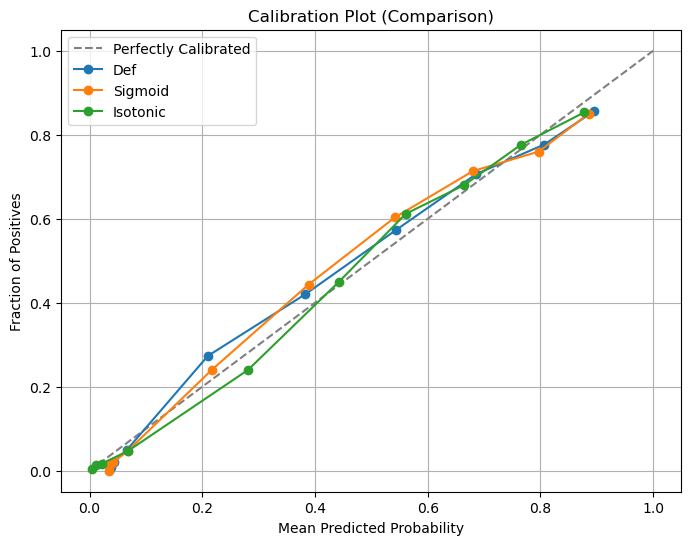

In [16]:
stacking_model.fit(X_train[columns], y_train)
y_prob = stacking_model.predict_proba(X_test[columns])[:,1]
brier_def = brier_score_loss(y_test, y_prob)
print(f"Brier Score (Def): {brier_def:.4f}")

rf_sigmoid = CalibratedClassifierCV(stacking_model, method='sigmoid', cv=skf, n_jobs=-1)
rf_sigmoid.fit(X_train, y_train)
y_prob_sigmoid = rf_sigmoid.predict_proba(X_test)[:,1]
brier_sigmoid = brier_score_loss(y_test, y_prob_sigmoid)
print(f"Brier Score (Sigmoid): {brier_sigmoid:.4f}")

rf_isotonic = CalibratedClassifierCV(stacking_model, method='isotonic', cv=skf, n_jobs=-1)
rf_isotonic.fit(X_train, y_train)
y_prob_isotonic = rf_isotonic.predict_proba(X_test)[:,1]
brier_isotonic = brier_score_loss(y_test, y_prob_isotonic)
print(f"Brier Score (Isotonic): {brier_isotonic:.4f}")

plot_calibration_curve(
    y_test,
    [y_prob, y_prob_sigmoid, y_prob_isotonic],
    ['Def', 'Sigmoid', 'Isotonic'],
    'Calibration Plot (Comparison)'
)

In [17]:
print('ROC-AUC (def)     ', round(roc_auc_score(y_test, y_prob),5))
print('ROC-AUC (sigmoid) ', round(roc_auc_score(y_test, y_prob_sigmoid),5))
print('ROC-AUC (isotonic)', round(roc_auc_score(y_test, y_prob_isotonic),5))

ROC-AUC (def)      0.89425
ROC-AUC (sigmoid)  0.89379
ROC-AUC (isotonic) 0.89344
